In [1]:
import h5py
import torch
import numpy as np
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json

device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
results = {}

In [2]:
# This becomes the subdir under the dir with modelname; use it to indicate other experiment details
# Besides model name, which indicates architecture / forward pass
# So use it to indicate regularization, loss function, optimizer, etc.
experiment_name = "cos_adam"

#### Set up datasets, get baseline stats

In [3]:
class TripletDataset(Dataset):
    def __init__(self, h5_path: str):
        with h5py.File(h5_path, "r") as f:
            self.triplets = torch.from_numpy(f["triplets"][:]).float()

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor = self.triplets[idx, 0, :]
        positive = self.triplets[idx, 1, :]
        negative = self.triplets[idx, 2, :]
        return anchor, positive, negative


train_dataset = TripletDataset("../src/citeline/nn/np_vectors_train_triplets.h5")
val_dataset = TripletDataset("../src/citeline/nn/np_vectors_val_triplets.h5")
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Check initial similarities in the raw data
ap_distances = []
an_distances = []
margins = []
for anchor, pos, neg in val_dataset:
    ap_dist = 1 - F.cosine_similarity(anchor.unsqueeze(0), pos.unsqueeze(0)).item()
    an_dist = 1 - F.cosine_similarity(anchor.unsqueeze(0), neg.unsqueeze(0)).item()
    ap_distances.append(ap_dist)
    an_distances.append(an_dist)
    margins.append(an_dist - ap_dist)

print(f"=== BASELINE ===")
print(f"Average Anchor-Positive distance: {np.mean(ap_distances):.4f} ± {np.std(ap_distances):.4f}")
print(f"Average Anchor-Negative distance: {np.mean(an_distances):.4f} ± {np.std(an_distances):.4f}")
print(f"Average margin in baseline data: {np.mean(margins):.4f}")

results['baseline'] = {
    'distances_to_positive': ap_distances,
    'distances_to_negative': an_distances,
    'margins': margins
}

Train dataset size: 52668
Validation dataset size: 11088
=== BASELINE ===
Average Anchor-Positive distance: 0.3744 ± 0.0970
Average Anchor-Negative distance: 0.3260 ± 0.0607
Average margin in baseline data: -0.0484


### 1. Define model architecture

In [4]:
class EmbeddingMapper(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1024, hidden_dim=256):  # Reduced from 512
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.final = nn.Linear(128, output_dim)
        self.residual_scale = nn.Parameter(torch.tensor(0.01))

        nn.init.xavier_uniform_(self.fc1.weight, gain=0.1)
        nn.init.xavier_uniform_(self.final.weight, gain=0.1)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.final.bias)

    def forward(self, x):
        y = F.tanh(self.fc1(x))
        y = F.tanh(self.final(y))
        y = x + self.residual_scale * y  # Residual connection

        y = F.normalize(y, p=2, dim=1)
        return y

# TODO: move this to an import
model = EmbeddingMapper(input_dim=1024, output_dim=1024).to(device)
results["model_name"] = model.__class__.__name__

### 2. Choose optimizer, learning rate, and weight decay (if any)

In [5]:
results['lr'] = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=results['lr'])
# optimizer = torch.optim.AdamW(model.parameters(), lr=results['lr'], weight_decay=1e-4)

### 3. Define loss function / loss function schedule

In [6]:
results['loss_function'] = 'CosineEmbeddingLoss with margin=0.1'
cosine_loss = nn.CosineEmbeddingLoss(margin=0.1)

loss_function = lambda a, p, n: cosine_loss(a, p, torch.ones(a.size(0)).to(device))

=== BEFORE TRAINING (Validation set, Anchor mapped, Pos/Neg unchanged) ===
Anchor-Positive distance: 0.3744, +0.0000% vs. baseline
Anchor-Negative distance: 0.3260, +0.0000% vs. baseline
Average margin: -0.0484


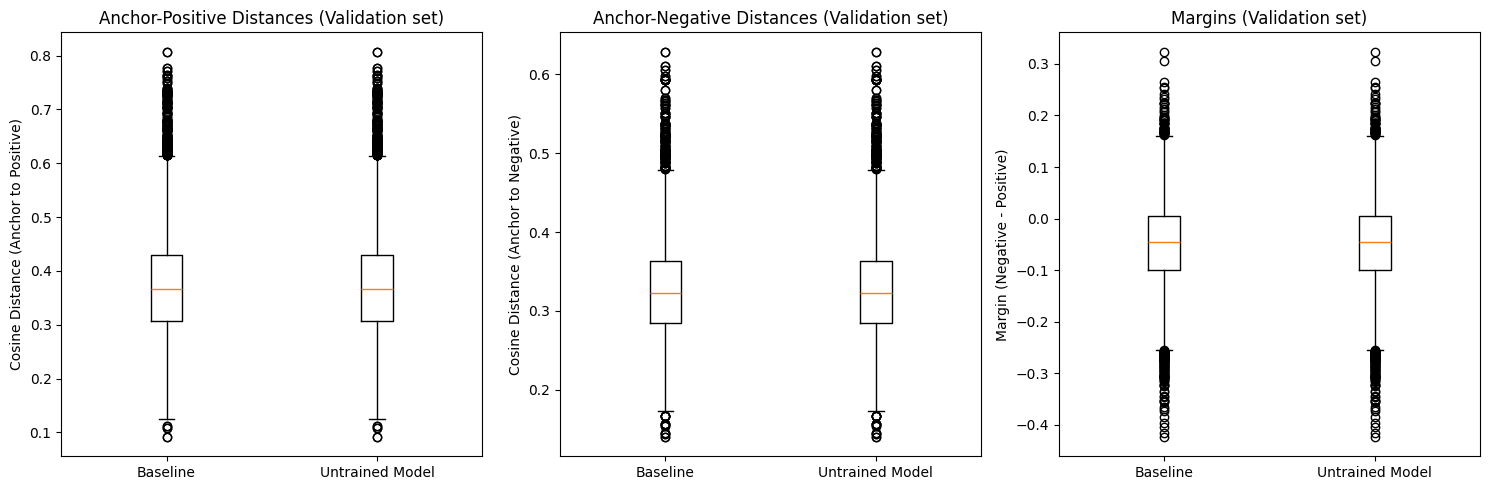

In [7]:
# Baseline loss
with torch.no_grad():
    model.eval()
    val_losses = []
    for anchors, positives, negatives in val_dataloader:
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        anchor_out = model(anchors)
        val_loss = loss_function(anchor_out, positives, negatives)
        val_losses.append(val_loss.item())

    # Check that the untrained model isn't starting from a point where it's perturbing the data far away from positives
    for name, dataset in [("Validation", val_dataset)]:
        ap_distances_after = []
        an_distances_after = []

        with torch.no_grad():
            for anchor, pos, neg in list(dataset):
                anchor = anchor.to(device).unsqueeze(0)

                anchor_emb = model(anchor)  # Only transform anchor

                # Compare to raw positive/negative (no transformation)
                ap_dist = 1 - F.cosine_similarity(anchor_emb, pos.unsqueeze(0).to(device)).item()
                an_dist = 1 - F.cosine_similarity(anchor_emb, neg.unsqueeze(0).to(device)).item()

                ap_distances_after.append(ap_dist)
                an_distances_after.append(an_dist)

        anchor_positive_mean_distance = np.mean(ap_distances_after)
        anchor_negative_mean_distance = np.mean(an_distances_after)
        ap_pct_diff = ((anchor_positive_mean_distance - np.mean(ap_distances)) / np.mean(ap_distances)) * 100
        an_pct_diff = ((anchor_negative_mean_distance - np.mean(an_distances)) / np.mean(an_distances)) * 100
        print(f"=== BEFORE TRAINING ({name} set, Anchor mapped, Pos/Neg unchanged) ===")
        print(f"Anchor-Positive distance: {anchor_positive_mean_distance:.4f}, {ap_pct_diff:+.4f}% vs. baseline")
        print(f"Anchor-Negative distance: {anchor_negative_mean_distance:.4f}, {an_pct_diff:+.4f}% vs. baseline")
        print(f"Average margin: {anchor_negative_mean_distance - anchor_positive_mean_distance:.4f}")

        if abs(ap_pct_diff) > 5.0:
            print("WARNING: Untrained model is changing Anchor-Positive distances significantly!")
        if abs(an_pct_diff) > 5.0:
            print("WARNING: Untrained model is changing Anchor-Negative distances significantly!")
            
        # Box plot the results
        results['untrained'] = {
            'distances_to_positive': ap_distances_after,
            'distances_to_negative': an_distances_after,
            'margins': [an - ap for ap, an in zip(ap_distances_after, an_distances_after)]
        }
        # Box plot ap_distances against ap_distances_after
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].boxplot([ap_distances, ap_distances_after], tick_labels=['Baseline', 'Untrained Model'])
        axes[0].set_ylabel('Cosine Distance (Anchor to Positive)')
        axes[0].set_title(f"Anchor-Positive Distances ({name} set)")

        axes[1].boxplot([an_distances, an_distances_after], tick_labels=['Baseline', 'Untrained Model'])
        axes[1].set_ylabel('Cosine Distance (Anchor to Negative)')
        axes[1].set_title(f"Anchor-Negative Distances ({name} set)")

        axes[2].boxplot([results['baseline']['margins'], results['untrained']['margins']], tick_labels=['Baseline', 'Untrained Model'])
        axes[2].set_ylabel('Margin (Negative - Positive)')
        axes[2].set_title(f"Margins ({name} set)")

        plt.tight_layout()
        plt.show()



In [8]:
train_loss_history = []
val_loss_history = []
pos_dist_weight = 1.0
NUM_EPOCHS = 20
min_val_loss = float("inf")
for epoch in range(NUM_EPOCHS):
    # ---- Training ----
    model.train()
    train_losses = []
    for batch_idx, (anchors, positives, negatives) in enumerate(train_dataloader):
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        optimizer.zero_grad()
        anchor_out = model(anchors)

        loss = loss_function(anchor_out, positives, negatives) 
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss_epoch = np.mean(train_losses)
    train_loss_history.append(train_loss_epoch)

    # ---- Validation ----
    model.eval()
    val_losses = []
    with torch.no_grad():
        for anchors, positives, negatives in val_dataloader:
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
            anchor_out = model(anchors)

            loss = loss_function(anchor_out, positives, negatives) 

            val_losses.append(loss.item())

    val_loss_epoch = np.mean(val_losses)
    val_loss_history.append(val_loss_epoch)
    if val_loss_epoch < min_val_loss:
        min_val_loss = val_loss_epoch
        # Save the best model
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch {epoch}: Train Loss = {train_loss_epoch:.4f}, Val Loss = {val_loss_epoch:.4f}")

Epoch 0: Train Loss = 0.3196, Val Loss = 0.3057
Epoch 1: Train Loss = 0.3008, Val Loss = 0.2931
Epoch 2: Train Loss = 0.2931, Val Loss = 0.2897
Epoch 3: Train Loss = 0.2897, Val Loss = 0.2874
Epoch 4: Train Loss = 0.2868, Val Loss = 0.2856
Epoch 5: Train Loss = 0.2844, Val Loss = 0.2842
Epoch 6: Train Loss = 0.2823, Val Loss = 0.2831
Epoch 7: Train Loss = 0.2805, Val Loss = 0.2823
Epoch 8: Train Loss = 0.2790, Val Loss = 0.2817
Epoch 9: Train Loss = 0.2777, Val Loss = 0.2812
Epoch 10: Train Loss = 0.2764, Val Loss = 0.2808
Epoch 11: Train Loss = 0.2753, Val Loss = 0.2807
Epoch 12: Train Loss = 0.2743, Val Loss = 0.2803
Epoch 13: Train Loss = 0.2734, Val Loss = 0.2802
Epoch 14: Train Loss = 0.2726, Val Loss = 0.2801
Epoch 15: Train Loss = 0.2719, Val Loss = 0.2800
Epoch 16: Train Loss = 0.2711, Val Loss = 0.2799
Epoch 17: Train Loss = 0.2705, Val Loss = 0.2799
Epoch 18: Train Loss = 0.2699, Val Loss = 0.2797
Epoch 19: Train Loss = 0.2693, Val Loss = 0.2800


In [9]:
results['training_loss'] = train_loss_history
results['validation_loss'] = val_loss_history

In [10]:
subdir = experiment_name + time.strftime("_%Y%m%d_%H%M%S")
save_dir = Path(model_name) / subdir
save_dir.mkdir(parents=True, exist_ok=True)

# Save model trace
sample = torch.randn(1, 1024).to(device)
trace = torch.jit.trace(model, sample)
torch.jit.save(trace, save_dir / f"{results['model_name']}_traced.pth")

with open(save_dir / "results.json", "w") as f:
    json.dump(results, f, indent=2)



NameError: name 'model_name' is not defined

In [ ]:
# Plot train and validation loss
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Add a notation where the minimal val loss occurred and amount
min_val_loss = min(val_loss_history)
min_val_loss_epoch = val_loss_history.index(min_val_loss)

# Mark the point
plt.plot(min_val_loss_epoch, min_val_loss, "ro", markersize=8)

# Add annotation with box
plt.annotate(
    f"Min: {min_val_loss:.4f}",
    xy=(min_val_loss_epoch, min_val_loss),
    xytext=(10, 10),  # Offset in points
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.5", facecolor="orange", alpha=0.3),
    # arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
)

plt.title("Training and Validation Loss")
plt.savefig(save_dir / "loss_curve.png")  # Save BEFORE show
plt.show()

In [ ]:
# Side by side boxplots of baseline distances to distances after training
model.eval()
for name, dataset in [("Validation", val_dataset)]:
    ap_distances_after = []
    an_distances_after = []

    with torch.no_grad():
        for anchor, pos, neg in list(dataset):
            anchor = anchor.to(device).unsqueeze(0)

            anchor_emb = model(anchor)  # Only transform anchor

            # Compare to raw positive/negative (no transformation)
            ap_dist = 1 - F.cosine_similarity(anchor_emb, pos.unsqueeze(0).to(device)).item()
            an_dist = 1 - F.cosine_similarity(anchor_emb, neg.unsqueeze(0).to(device)).item()

            ap_distances_after.append(ap_dist)
            an_distances_after.append(an_dist)

    anchor_positive_mean_distance = np.mean(ap_distances_after)
    anchor_negative_mean_distance = np.mean(an_distances_after)
    margins_trained = [an - ap for ap, an in zip(ap_distances_after, an_distances_after)]
    print(f"=== AFTER TRAINING ({name} set, Anchor mapped, Pos/Neg unchanged) ===")
    print(f"Anchor-Positive distance: {anchor_positive_mean_distance:.4f} ± {np.std(ap_distances_after):.4f}")
    print(f"Anchor-Negative distance: {anchor_negative_mean_distance:.4f} ± {np.std(an_distances_after):.4f}")
    print(f"Average margin: {anchor_negative_mean_distance - anchor_positive_mean_distance:.4f}")
    print(f"Learned margin mean: {np.mean(margins_trained):.4f} ± {np.std(margins_trained):.4f}")
    print(f"Learned margin median: {np.median(margins_trained):.4f}")
    print(f"Distribution of margins: min={np.min(margins_trained):.4f}, max={np.max(margins_trained):.4f}")

    # Box plot the results
    results['trained'] = {
        'distances_to_positive': ap_distances_after,
        'distances_to_negative': an_distances_after,
        'margins': [an - ap for ap, an in zip(ap_distances_after, an_distances_after)]
    }
    # Box plot ap_distances against ap_distances_after
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].boxplot([results['baseline']['distances_to_positive'], results['trained']['distances_to_positive']], tick_labels=['Baseline', 'Trained Model'])
    axes[0].set_ylabel('Cosine Distance')
    axes[0].set_title(f"Anchor-Positive Distances ({name} set)")

    axes[1].boxplot([results['baseline']['distances_to_negative'], results['trained']['distances_to_negative']], tick_labels=['Baseline', 'Trained Model'])
    axes[1].set_ylabel('Cosine Distance')
    axes[1].set_title(f"Anchor-Negative Distances ({name} set)")

    axes[2].boxplot([results['baseline']['margins'], results['trained']['margins']], tick_labels=['Baseline', 'Trained Model'])
    axes[2].set_ylabel('Distance(Negative) - Distance(Positive)')
    axes[2].set_title(f"Margins ({name} set)")

    plt.tight_layout()
    plt.savefig(save_dir / "val_distances_boxplot.png")  # Save BEFORE show
    plt.show()

In [ ]:
model.__class__.__name__